# Fake News Classification with DistilBERT and LoRA

This project demonstrates the process of building a deep learning model to identify fake news articles. It uses the pre-trained DistilBERT transformer model and fine-tunes it using LoRA (Low-Rank Adaptation) on the [WelFake dataset](https://zenodo.org/records/4561253).\


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -r "/content/drive/MyDrive/fake/requirements.txt"

In [ ]:
import os
import time
import warnings

import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict

from peft import LoraConfig, get_peft_model, TaskType

from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
    get_scheduler,
)

In [ ]:
def count_trainable_params(model):
    trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())

    percentage = 100 * trainable_params / all_params
    return f"{all_params} total parameters.\n{trainable_params} trainable parameters ({percentage:.2f}%)"

In [ ]:
start_time = time.perf_counter()

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


model_id = "distilbert/distilbert-base-uncased"

warnings.simplefilter(action="ignore", category=FutureWarning)
plt.style.use("ggplot")

## Data Preparation


The WELFake dataset was loaded and inspected for duplicates and missing values.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/fake/WELFake_Dataset.csv", index_col=0)

df.duplicated().sum()

8456

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

df.isna().sum()

title    518
text      39
label      0
dtype: int64

Duplicates (8456) and rows with missing values in `title` (518) and `text` (39) were removed.


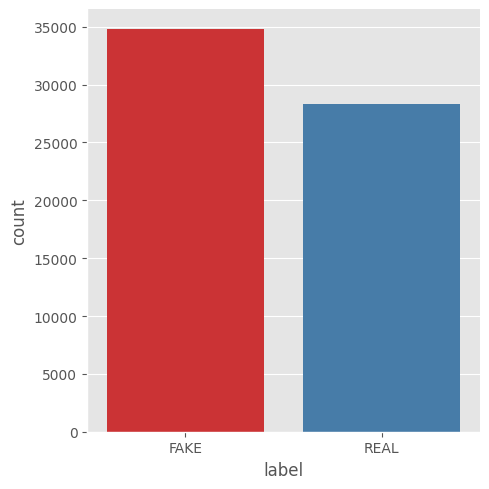

In [ ]:
df = df.dropna()
g = sns.catplot(kind="count", data=df, x="label", hue="label", palette="Set1", legend=False)
g.set_xticklabels(["FAKE", "REAL"])
# plt.xlabel("Label")
plt.show()

Balancing the dataset and sampling 10,000 articles.


In [ ]:
n_per_class = 5000
df = df.groupby("label").apply(lambda x: x.sample(n_per_class))

In [ ]:
df["label"].value_counts()

label
0    5000
1    5000
Name: count, dtype: int64

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.shape

(10000, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   10000 non-null  object
 1   text    10000 non-null  object
 2   label   10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


## Tokenization and Dataset Creation

Here, we prepare our data for the model:

1. Convert the text to lowercase
2. Create a Dataset object using the Hugging Face datasets library
3. Split the data into training, validation, and test sets
4. Tokenize the text data using the DistilBERT tokenizer


In [ ]:
df["text"] = df["text"].str.lower()
df["title"] = df["title"].str.lower()

df.head()

,title,text,label
0,rep. mark sanford: gop house leadership bill a...,south carolina republican rep. mark sanford to...,0
1,republican house speaker ryan not ready to sup...,washington (reuters) - the top elected republi...,0
2,u.s. 'disappointed' by india's visa refusal fo...,washington (reuters) - the u.s. state departme...,0
3,"under trump, congress likely to pull plug on m...","warsaw, indiana/washington (reuters) - when do...",0
4,epa official resigns over flint water crisis,washington/chicago (reuters) - the head of the...,0


In [ ]:
ds = Dataset.from_pandas(df)
ds = ds.class_encode_column("label")

train_testvalid = ds.train_test_split(test_size=0.4)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5)
datasets = DatasetDict(
    {
        "train": train_testvalid["train"],
        "test": test_valid["test"],
        "valid": test_valid["train"],
    }
)
train_ds = datasets["train"]
valid_ds = datasets["valid"]
test_ds = datasets["test"]

Stringifying the column:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)


def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=True,
    )


tokenized_train_ds = train_ds.map(tokenize, batched=True)
tokenized_val_ds = valid_ds.map(tokenize, batched=True)
tokenized_test_ds = test_ds.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Model Configuration and LoRA Setup

LoRA (Low-Rank Adaptation) is a technique that allows us to fine-tune large language models more efficiently by reducing the number of trainable parameters. This significantly reduces the computational resources required for training while maintaining performance.


In [ ]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

metric = evaluate.combine(["accuracy", "precision", "recall", "f1"])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)


def early_stopping():
    return EarlyStoppingCallback(early_stopping_patience=3)

In [ ]:
id2label = {0: "FAKE", 1: "REAL"}
label2id = {"FAKE": 0, "REAL": 1}

config = AutoConfig.from_pretrained(model_id, num_labels=2, id2label=id2label, label2id=label2id)

model = AutoModelForSequenceClassification.from_config(config)

print(count_trainable_params(model))

66955010 total parameters.
66955010 trainable parameters (100.00%)


In [ ]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    lora_dropout=0.01,
    target_modules=["q_lin", "k_lin", "v_lin"],
    bias="none",
    task_type=TaskType.SEQ_CLS,
)

In [ ]:
peft_model = get_peft_model(model, lora_config)

print(count_trainable_params(peft_model))

67657732 total parameters.
702722 trainable parameters (1.04%)


## Training Setup

Here, we set up the optimizer (AdamW), learning rate scheduler, and other training parameters. We use early stopping to prevent overfitting and evaluate the model periodically during training. Training is stopped if the validation performance does not improve for 3 consecutive evaluations.


In [ ]:
optimizer = AdamW(peft_model.parameters(), lr=1e-4, no_deprecation_warning=True)

In [ ]:
import math

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

training_args = TrainingArguments(
    output_dir="output",
    learning_rate=0.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=128,
    save_steps=128,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

# Define Scheduler
n_epochs = training_args.num_train_epochs
total_steps = n_epochs * math.ceil(len(tokenized_train_ds) / training_args.per_device_train_batch_size / 2)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)


trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
    callbacks=[early_stopping()],
)

## Model Training and Evaluation


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
128,No log,0.602124,0.577500,0.530396,0.996855,0.692392
256,No log,0.308546,0.876500,0.919336,0.812369,0.862549
384,No log,0.271985,0.903500,0.860664,0.951782,0.903932
512,0.402100,0.233980,0.906500,0.916395,0.884696,0.900267
640,0.402100,0.212227,0.911500,0.900929,0.915094,0.907956
768,0.402100,0.201744,0.915500,0.924324,0.896226,0.910059
896,0.402100,0.197348,0.918500,0.902340,0.929769,0.915849
1024,0.231600,0.196787,0.916500,0.909469,0.916143,0.912794
1152,0.231600,0.196787,0.916500,0.909469,0.916143,0.912794
1280,0.231600,0.196787,0.916500,0.909469,0.916143,0.912794


TrainOutput(global_step=1280, training_loss=0.29186676144599916, metrics={'train_runtime': 1139.5239, 'train_samples_per_second': 26.327, 'train_steps_per_second': 1.645, 'total_flos': 2757143769907200.0, 'train_loss': 0.29186676144599916, 'epoch': 3.413333333333333})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.19734767079353333,
 'eval_accuracy': 0.9185,
 'eval_precision': 0.9023397761953205,
 'eval_recall': 0.929769392033543,
 'eval_f1': 0.9158492514197213,
 'eval_runtime': 35.6067,
 'eval_samples_per_second': 56.169,
 'eval_steps_per_second': 3.511,
 'epoch': 3.413333333333333}

#### Classification report

The classification report provides precision, recall, and F1-score for each class (fake and real) as well as overall accuracy.


In [ ]:
from sklearn.metrics import classification_report

pred = trainer.predict(test_dataset=tokenized_test_ds)

In [ ]:
y_true = test_ds["label"]

y_pred = np.argmax(pred.predictions, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1000
           1       0.91      0.91      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [ ]:
pred.metrics

{'test_loss': 0.2356836497783661,
 'test_accuracy': 0.909,
 'test_precision': 0.9114688128772636,
 'test_recall': 0.906,
 'test_f1': 0.9087261785356068,
 'test_runtime': 35.6144,
 'test_samples_per_second': 56.157,
 'test_steps_per_second': 3.51}

## Confusion matrix

Here, we visualize the model's performance per class with a heatmap of the confusion matrix.

- False Positives: Fake news misclassified as real
- False Negatives: Real news misclassified as fake
- True Positives: Correctly identified real news
- True Negatives: Correctly identified fake news


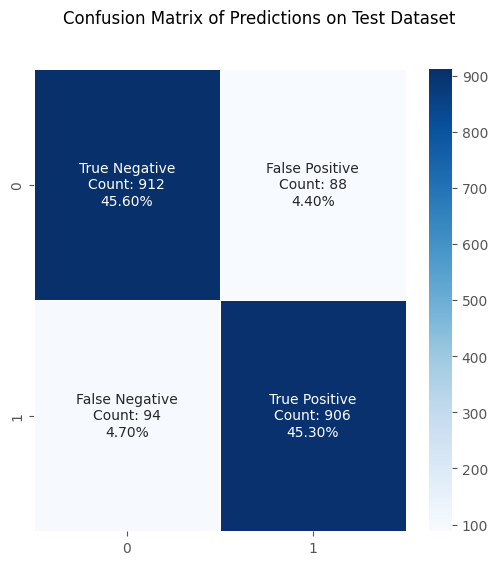

array([0.456, 0.044, 0.047, 0.453])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

cm_descriptions = ["True Negative", "False Positive", "False Negative", "True Positive"]
cm_counts = cm.flatten()
cm_percentages = ["{0:.2%}".format(p) for p in cm.flatten() / np.sum(cm)]
cm_labels = [f"{d}\nCount: {c}\n{p}" for d, c, p in zip(cm_descriptions, cm_counts, cm_percentages)]
cm_labels = np.asarray(cm_labels).reshape(2, 2)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=cm_labels, linewidth=0.5, fmt="", cmap="Blues", ax=ax)
plt.xlabel = "y_pred"
plt.ylabel = "y_true"
fig.suptitle("Confusion Matrix of Predictions on Test Dataset")

plt.show()
cm.flatten() / np.sum(cm)

In [ ]:
model.save_pretrained("output/model")
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): lora.Linear(
              (base_layer): Linear(in_features=768, out_features=768, bias=True)
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.01, inplace=False)
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=768, out_features=4, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=4, out_features=768, bi

In [ ]:
end_time = time.perf_counter()
duration = end_time - start_time
minutes, seconds = divmod(duration, 60)
print(f"Process completed in {minutes:0.0f} minutes and {seconds:0.0f} seconds")

Process completed in 21 minutes and 43 seconds
